# Quality metrics for classification

We will consider a range of classification quality metrics solving a classification problem with a neural network.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt

# Load MAGIC Data Set

<center><img src="https://github.com/HSE-LAMBDA/ML-IDS/blob/main/course_1/4_topic/4_classification_metrics/img/magic1.jpg?raw=1" width="1000"></center>

Source: https://magic.mpp.mpg.de/

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

--2021-11-24 21:12:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1.4M) [application/x-httpd-php]
Saving to: ‘magic04.data’

magic04.data        100%[===================>]   1.41M  3.17MB/s    in 0.4s    

2021-11-24 21:12:25 (3.17 MB/s) - ‘magic04.data’ saved [1477391/1477391]



Features description:
- **Length:** continuous # major axis of ellipse [mm]
- **Width:** continuous # minor axis of ellipse [mm]
- **Size:** continuous # 10-log of sum of content of all pixels [in #phot]
- **Conc:** continuous # ratio of sum of two highest pixels over fSize [ratio]
- **Conc1:** continuous # ratio of highest pixel over fSize [ratio]
- **Asym:** continuous # distance from highest pixel to center, projected onto major axis [mm]
- **M3Long:** continuous # 3rd root of third moment along major axis [mm]
- **M3Trans:** continuous # 3rd root of third moment along minor axis [mm]
- **Alpha:** continuous # angle of major axis with vector to origin [deg]
- **Dist:** continuous # distance from origin to center of ellipse [mm]
- **Label:** g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 \
h = hadron (background): 6688

In [3]:
f_names = np.array(["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist"])

data = pd.read_csv("magic04.data", header=None, names=list(f_names)+["Label"])
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Data preparation

In [4]:
# prepare a matrix of input features
X = data[f_names].values

# prepare a vector of true labels
y = 1 * (data['Label'].values == "g")

In [5]:
# print sizes of X and y
X.shape, y.shape

((19020, 10), (19020,))

In [6]:
X[:2]

array([[ 2.87967e+01,  1.60021e+01,  2.64490e+00,  3.91800e-01,
         1.98200e-01,  2.77004e+01,  2.20110e+01, -8.20270e+00,
         4.00920e+01,  8.18828e+01],
       [ 3.16036e+01,  1.17235e+01,  2.51850e+00,  5.30300e-01,
         3.77300e-01,  2.62722e+01,  2.38238e+01, -9.95740e+00,
         6.36090e+00,  2.05261e+02]])

In [7]:
y[:5]

array([1, 1, 1, 1, 1])

# Train / test split

In [8]:
from sklearn.model_selection import train_test_split

# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Preprocessing

Scale input data using StandardScaler:
$$
X_{new} = \frac{X - \mu}{\sigma}
$$

In [9]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Create object of the class and set up its parameters
ss = StandardScaler()

# Estimate mean and sigma values
ss.fit(X_train)

# Scale train and test samples
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# Fit a classifier


Now let's create a neural network and fit it.

In [11]:
pip install pytorch-lightning

     |████████████████████████████████| 523 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
     |████████████████████████████████| 829 kB 57.0 MB/s 
     |████████████████████████████████| 132 kB 65.3 MB/s 
     |████████████████████████████████| 329 kB 61.1 MB/s 
     |████████████████████████████████| 1.1 MB 68.2 MB/s 
     |████████████████████████████████| 271 kB 50.3 MB/s 
     |████████████████████████████████| 160 kB 51.1 MB/s 
     |████████████████████████████████| 192 kB 60.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=04899831685886ce1f9446935d6e284bf678d02fccba6b761a44243871758290
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [12]:
import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl

class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        # define all layers of the netwrok
        self.net = nn.Sequential(
                                nn.Linear(10, 10), 
                                nn.Tanh(), 
                                nn.Linear(10, 1), 
                                nn.Sigmoid())

    
    def forward(self, x):
        # make a prediction for x
        return self.net(x)

    # calculate loss function values
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        return loss

    # define optimizer to fit the network
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# combine X and y into one pytorch tensor dataset
dataset_train = TensorDataset(torch.tensor(X_train, dtype=torch.float), 
                              torch.tensor(y_train.reshape(-1, 1), dtype=torch.float))

# loader divides our train data into batches
train_loader = DataLoader(dataset_train, batch_size=128)

In [14]:
# define trainer to fit out network
trainer = pl.Trainer(max_epochs=10)

# init our netwrok
model = Model()

# fit the netwrok
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 121   
------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Make Predictions

Make prediction of **probability** of the positive class.

In [15]:
# make predictions
y_proba_test = model(torch.tensor(X_test, dtype=torch.float))[:, 0].detach().numpy()

In [16]:
print("Truth  : ", y_test[:10])
print("Proba  : ", y_proba_test[:10])

Truth  :  [1 1 0 1 0 1 0 1 1 1]
Proba  :  [0.9210064  0.70332885 0.30282676 0.9886269  0.514649   0.9670445
 0.04128045 0.8787017  0.9061171  0.72650313]


Make prediction of class **label**.

In [17]:
# transform the predicted probabilities into predicted labels {0, 1}
y_pred_test = 1 * (y_proba_test > 0.5)

In [18]:
print("Truth  : ", y_test[:10])
print("Pred   : ", y_pred_test[:10])

Truth  :  [1 1 0 1 0 1 0 1 1 1]
Pred   :  [1 1 0 1 1 1 0 1 1 1]


# Label-based Quality Metrics

Consider a confusion matrix:

<center><img src='https://github.com/HSE-LAMBDA/ML-IDS/blob/main/course_1/4_topic/4_classification_metrics/img/cm.png?raw=1'></center>


* TP (true positive) - currectly predicted positives
* FP (false positive) - incorrectly predicted negatives (1st order error)
* FN (false negative) - incorrectly predicted positives (2nd order error)
* TN (true negative) - currectly predicted negatives
* Pos (Neg) - total number of positives (negatives)

Quality metrics:

* $ \text{Accuracy} = \frac{TP + TN}{Pos+Neg}$
* $ \text{Error rate} = 1 -\text{accuracy}$
* $ \text{Precision} =\frac{TP}{TP + FP}$ 
* $ \text{Recall} =\frac{TP}{TP + FN} = \frac{TP}{Pos}$
* $ \text{F}_\beta \text{-score} = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$

### Task 1
Complete a function that computes TP, FP, TN, FN, Accuracy, Error rate, Precision, Recall and F1-score metrics for a classifier.

**Hint:** use implementation of the metrics from `sklearn.metrics` as it is shown below. Example for confusin matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def quality_metrics_report(y_true, y_pred):
    """
    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
        
    Returns
    -------
    List of metric values: [tp, fp, fn, tn, accuracy, error_rate, precision, recall, f1]
    """
    
    ### BEGIN SOLUTION
    tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    error_rate = 1 - accuracy
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    ### END SOLUTION
    
    return [tp, fp, fn, tn, accuracy, error_rate, precision, recall, f1]

In [22]:
quality_metrics_report([0, 1, 0, 1], [1, 1, 1, 0])

[1, 2, 1, 0, 0.25, 0.75, 0.3333333333333333, 0.5, 0.4]

Expected output:

<center>   
    
```python
[1, 2, 1, 0, 0.25, 0.75, 0.3333333333333333, 0.5, 0.4]
    
``` 
    
</center>

In [23]:
### BEGIN HIDDEN TESTS
actual  = quality_metrics_report([0, 1, 0, 1], [1, 1, 1, 0])
desired = [1, 2, 1, 0, 0.25, 0.75, 0.3333333333333333, 0.5, 0.4]
np_testing.assert_almost_equal(actual, desired, decimal=1)
### END HIDDEN TESTS

Now let's compute all these quality metrics for all classifiers considered above.

In [24]:
metrics_report = pd.DataFrame(columns=['TP', 'FP', 'FN', 'TN', 'Accuracy', 'Error rate', 'Precision', 'Recall', 'F1'])

metrics_report.loc['Model', :] = quality_metrics_report(y_test, y_pred_test)

metrics_report

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall,F1
Model,1,2,1,0,0.856677,0.143323,0.875176,0.908531,0.891541


## Probability-based Quality Metrics

### ROC curve

The receiver operating characteristic curve (ROC) measures how well a classifier separates two classes. 

Let $y_{\rm i}$ is a true label and $\hat{y}_{\rm i}$ is a predicted score for the $i^{\rm th}$ observation. 

The numbers of positive and negative observations: $\mathcal{I}_{\rm 1} = \{i: y_{\rm i}=1\}$ and $\mathcal{I}_{\rm 0} = \{i: y_{\rm i}=0\}$. 

The sum of observation weights for each class: $W_{\rm 1} = \sum_{i \in \mathcal{I}_{\rm 1}} w_{\rm i}$ and  $W_{\rm 0} = \sum_{i \in \mathcal{I}_{\rm 0}} w_{\rm i}$. 

For each predicted score threshold value $\tau$, True Positive Rate (TPR) and False Positive Rate (FPR) are calculated:

\begin{equation}
TPR(\tau) = \frac{1}{W_{\rm 1}} \sum_{i \in \mathcal{I}_{\rm 1}} I[\hat{y}_{\rm i} \ge \tau] w_{\rm i}
\end{equation}

\begin{equation}
FPR(\tau) = \frac{1}{W_{\rm 0}} \sum_{i \in \mathcal{I}_{\rm 0}} I[\hat{y}_{\rm i} \ge \tau] w_{\rm i}
\end{equation}

### Task 2
Complete the fucntion below, that computes a ROC curve and ROC AUC for a classifier.

**Hint:** use `roc_curve` and `auc` from `from sklearn.metrics`.

In [34]:
from sklearn.metrics import roc_curve, auc

def roc_curve_report(y_true, y_proba):
    """
    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_proba: array-like of shape (n_samples,)
        Predicted probabilities of the positive class predicted by a classifier.
        
    Returns
    -------
    fpr : array, shape = [>2]
        Increasing false positive rates such that element i is the false
        positive rate of predictions with score >= thresholds[i].
    tpr : array, shape = [>2]
        Increasing true positive rates such that element i is the true
        positive rate of predictions with score >= thresholds[i].
    roc_auc : float
        Area under the ROC curve defined by the fpr and tpr.
    """
    
    ### BEGIN SOLUTION

    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    ### END SOLUTION
    
    return fpr, tpr, roc_auc

In [35]:
roc_curve_report([0, 1, 0, 1], [0.6, 0.9, 0.1, 0.4])

(array([0. , 0. , 0.5, 0.5, 1. ]), array([0. , 0.5, 0.5, 1. , 1. ]), 0.75)

Expected output:

<center>   
    
```python
(array([0. , 0. , 0.5, 0.5, 1. ]), array([0. , 0.5, 0.5, 1. , 1. ]), 0.75)
    
``` 
    
</center>

In [36]:
### BEGIN HIDDEN TESTS
actual  = roc_curve_report([0, 1, 0, 1], [0.6, 0.9, 0.1, 0.4])[0]
desired = np.array([0. , 0. , 0.5, 0.5, 1. ])
np_testing.assert_almost_equal(actual, desired, decimal=1)
### END HIDDEN TESTS

Now let's plot ROC curves for all classifiers considered above.

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = roc_curve_report(y_test, y_proba_test)

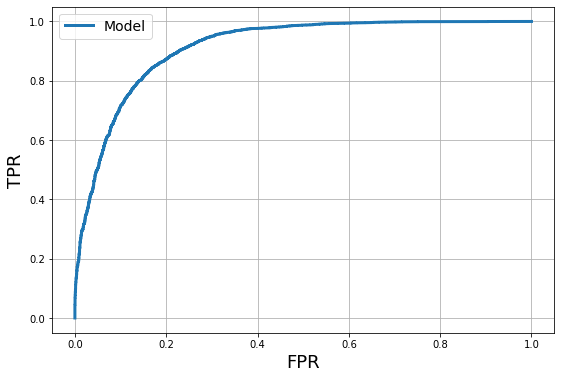

ROC AUC: 0.9136277211657694


In [38]:
plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, linewidth=3, label='Model')

plt.xlabel('FPR', size=18)
plt.ylabel('TPR', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

print('ROC AUC:', roc_auc)